# Library

In [1]:
pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Library to dataset
import opendatasets as od
import os
import zipfile
import numpy as np

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.xception import Xception

# Others
import shutil
import random

# Load dataset

In [4]:
# Download dataset
od.download('https://www.kaggle.com/datasets/ahmadhabibhasanzein/corn-leaves')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ahmadhabibhasanzein
Your Kaggle Key: ··········


100%|██████████| 244M/244M [00:06<00:00, 41.6MB/s]


In [5]:
# Load dataset
print("==========================Training Data====================")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/corn-leaves/Corn/train",
    label_mode="categorical",
    class_names=['Corn Gray leaf spot','Corn healthy','Corn leaf blight','Corn rust leaf'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)
print("==========================Validation Data====================")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/corn-leaves/Corn/valid",
    label_mode="categorical",
    class_names=['Corn Gray leaf spot','Corn healthy','Corn leaf blight','Corn rust leaf'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

==========================Training Data====================
Found 7665 files belonging to 4 classes.
==========================Validation Data====================
Found 1855 files belonging to 4 classes.


In [6]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale = 1.0/256.)
test_datagen  = ImageDataGenerator(rescale = 1.0/256.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory("/content/corn-leaves/Corn/train",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory("/content/corn-leaves/Corn/valid",
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 7665 images belonging to 4 classes.
Found 1855 images belonging to 4 classes.


# List Resource

In [ ]:
# Check GPU
!nvidia-smi

Sat May 20 07:17:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    26W /  70W |    375MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices("GPU")
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

# Modelling Without Augmentation

## Xception Model 1

In [7]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Corn_Xception_model1_Based_Non_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [8]:
# Define DIY Model
Xception_model = tf.keras.models.Sequential([
    # Xception121 Layer
    Xception(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Max Pooling Layer
    tf.keras.layers.GlobalMaxPooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(4, activation='softmax') 
  ])


# Compile Model
Xception_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
Xception_model.summary()

83683744/83683744 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 21,387,052
Trainable params: 21,332,524
Non

In [9]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_Xception_model_1 = Xception_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
384/384 [==============================] - ETA: 0s - loss: 0.3244 - accuracy: 0.8971
Epoch 1: val_accuracy improved from -inf to 0.95687, saving model to Corn_Xception_model1_Based_Non_Augmented


384/384 [==============================] - 212s 417ms/step - loss: 0.3244 - accuracy: 0.8971 - val_loss: 0.1715 - val_accuracy: 0.9569 - lr: 0.0010
Epoch 2/100
384/384 [==============================] - ETA: 0s - loss: 0.1951 - accuracy: 0.9399
Epoch 2: val_accuracy improved from 0.95687 to 0.97844, saving model to Corn_Xception_model1_Based_Non_Augmented


384/384 [==============================] - 161s 420ms/step - loss: 0.1951 - accuracy: 0.9399 - val_loss: 0.0707 - val_accuracy: 0.9784 - lr: 0.0010
Epoch 3/100
384/384 [==============================] - ETA: 0s - loss: 0.1509 - accuracy: 0.9495
Epoch 3: val_accuracy did not improve from 0.97844
384/384 [==============================] - 134s 349ms/step - loss: 0.1509 - accuracy: 0.9495 - val_loss: 0.1298 - val_accuracy: 0.9391 - lr: 0.0010
Epoch 4/100
384/384 [==============================] - ETA: 0s - loss: 0.1001 - accuracy: 0.9661
Epoch 4: val_accuracy did not improve from 0.97844
384/384 [==============================] - 133s 345ms/step - loss: 0.1001 - accuracy: 0.9661 - val_loss: 0.0866 - val_accuracy: 0.9698 - lr: 0.0010
Epoch 5/100
384/384 [==============================] - ETA: 0s - loss: 0.1312 - accuracy: 0.9601
Epoch 5: val_accuracy did not improve from 0.97844
384/384 [==============================] - 133s 346ms/step - loss: 0.1312 - accuracy: 0.9601 - val_loss: 0.1571 

384/384 [==============================] - 161s 420ms/step - loss: 0.0370 - accuracy: 0.9879 - val_loss: 0.0543 - val_accuracy: 0.9801 - lr: 1.0000e-04
Epoch 9/100
384/384 [==============================] - ETA: 0s - loss: 0.0185 - accuracy: 0.9947
Epoch 9: val_accuracy improved from 0.98005 to 0.98167, saving model to Corn_Xception_model1_Based_Non_Augmented


384/384 [==============================] - 161s 419ms/step - loss: 0.0185 - accuracy: 0.9947 - val_loss: 0.0570 - val_accuracy: 0.9817 - lr: 1.0000e-04
Epoch 10/100
384/384 [==============================] - ETA: 0s - loss: 0.0117 - accuracy: 0.9967
Epoch 10: val_accuracy improved from 0.98167 to 0.98275, saving model to Corn_Xception_model1_Based_Non_Augmented


384/384 [==============================] - 163s 424ms/step - loss: 0.0117 - accuracy: 0.9967 - val_loss: 0.0652 - val_accuracy: 0.9827 - lr: 1.0000e-04
Epoch 11/100
384/384 [==============================] - ETA: 0s - loss: 0.0070 - accuracy: 0.9983
Epoch 11: val_accuracy did not improve from 0.98275
384/384 [==============================] - 133s 347ms/step - loss: 0.0070 - accuracy: 0.9983 - val_loss: 0.0826 - val_accuracy: 0.9811 - lr: 1.0000e-04
Epoch 12/100
384/384 [==============================] - ETA: 0s - loss: 0.0143 - accuracy: 0.9967
Epoch 12: val_accuracy did not improve from 0.98275
384/384 [==============================] - 133s 345ms/step - loss: 0.0143 - accuracy: 0.9967 - val_loss: 0.0827 - val_accuracy: 0.9790 - lr: 1.0000e-04
Epoch 13/100
384/384 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 0.9983
Epoch 13: val_accuracy did not improve from 0.98275

Epoch 13: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
384/384 [======

Text(0.5, 1.0, 'Training and validation loss DIY Model')

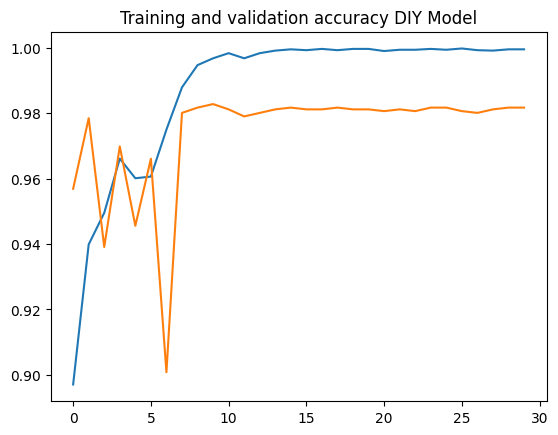

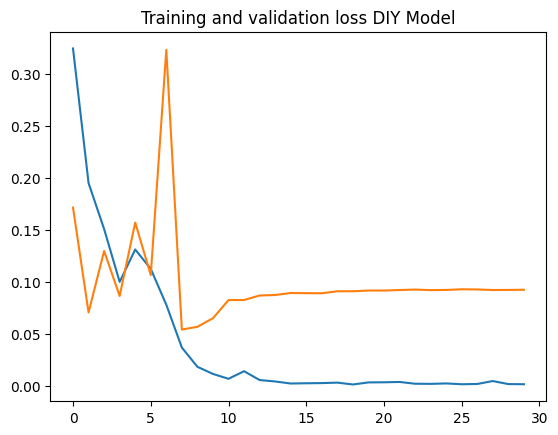

In [10]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_Xception_model_1.history['accuracy' ]
val_acc  = history_Xception_model_1.history['val_accuracy' ]
loss     = history_Xception_model_1.history['loss' ]
val_loss = history_Xception_model_1.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DIY Model')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DIY Model')

## Xception Model 2

In [11]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Corn_Xception_model2_Based_Non_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [12]:
# Define DIY Model
Xception_model_2 = tf.keras.models.Sequential([
    # Xception121 Layer
    Xception(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Average Pooling Layer
    tf.keras.layers.GlobalAveragePooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(4, activation='softmax') 
  ])


# Compile Model
Xception_model_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
Xception_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 21,387,052
Trainable params: 21,332,524
Non-trainable params: 54,528
_____________________________________

In [13]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_Xception_model_2 = Xception_model_2.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
384/384 [==============================] - ETA: 0s - loss: 0.2687 - accuracy: 0.9125
Epoch 1: val_accuracy improved from -inf to 0.91482, saving model to Corn_Xception_model2_Based_Non_Augmented


384/384 [==============================] - 190s 423ms/step - loss: 0.2687 - accuracy: 0.9125 - val_loss: 0.4977 - val_accuracy: 0.9148 - lr: 0.0010
Epoch 2/100
384/384 [==============================] - ETA: 0s - loss: 0.1525 - accuracy: 0.9486
Epoch 2: val_accuracy improved from 0.91482 to 0.94232, saving model to Corn_Xception_model2_Based_Non_Augmented


384/384 [==============================] - 162s 422ms/step - loss: 0.1525 - accuracy: 0.9486 - val_loss: 0.1889 - val_accuracy: 0.9423 - lr: 0.0010
Epoch 3/100
384/384 [==============================] - ETA: 0s - loss: 0.1485 - accuracy: 0.9538
Epoch 3: val_accuracy improved from 0.94232 to 0.95795, saving model to Corn_Xception_model2_Based_Non_Augmented


384/384 [==============================] - 161s 418ms/step - loss: 0.1485 - accuracy: 0.9538 - val_loss: 0.0953 - val_accuracy: 0.9580 - lr: 0.0010
Epoch 4/100
384/384 [==============================] - ETA: 0s - loss: 0.0879 - accuracy: 0.9697
Epoch 4: val_accuracy did not improve from 0.95795
384/384 [==============================] - 133s 347ms/step - loss: 0.0879 - accuracy: 0.9697 - val_loss: 0.2020 - val_accuracy: 0.9310 - lr: 0.0010
Epoch 5/100
384/384 [==============================] - ETA: 0s - loss: 0.0994 - accuracy: 0.9689
Epoch 5: val_accuracy improved from 0.95795 to 0.96712, saving model to Corn_Xception_model2_Based_Non_Augmented


384/384 [==============================] - 155s 404ms/step - loss: 0.0994 - accuracy: 0.9689 - val_loss: 0.0993 - val_accuracy: 0.9671 - lr: 0.0010
Epoch 6/100
384/384 [==============================] - ETA: 0s - loss: 0.1049 - accuracy: 0.9644
Epoch 6: val_accuracy did not improve from 0.96712
384/384 [==============================] - 133s 346ms/step - loss: 0.1049 - accuracy: 0.9644 - val_loss: 0.1369 - val_accuracy: 0.9558 - lr: 0.0010
Epoch 7/100
384/384 [==============================] - ETA: 0s - loss: 0.0730 - accuracy: 0.9751
Epoch 7: val_accuracy improved from 0.96712 to 0.97143, saving model to Corn_Xception_model2_Based_Non_Augmented


384/384 [==============================] - 160s 416ms/step - loss: 0.0730 - accuracy: 0.9751 - val_loss: 0.0867 - val_accuracy: 0.9714 - lr: 0.0010
Epoch 8/100
384/384 [==============================] - ETA: 0s - loss: 0.0752 - accuracy: 0.9761
Epoch 8: val_accuracy improved from 0.97143 to 0.98113, saving model to Corn_Xception_model2_Based_Non_Augmented


384/384 [==============================] - 157s 410ms/step - loss: 0.0752 - accuracy: 0.9761 - val_loss: 0.0575 - val_accuracy: 0.9811 - lr: 0.0010
Epoch 9/100
384/384 [==============================] - ETA: 0s - loss: 0.0453 - accuracy: 0.9845
Epoch 9: val_accuracy did not improve from 0.98113
384/384 [==============================] - 133s 346ms/step - loss: 0.0453 - accuracy: 0.9845 - val_loss: 0.0726 - val_accuracy: 0.9774 - lr: 0.0010
Epoch 10/100
384/384 [==============================] - ETA: 0s - loss: 0.0567 - accuracy: 0.9826
Epoch 10: val_accuracy did not improve from 0.98113
384/384 [==============================] - 132s 344ms/step - loss: 0.0567 - accuracy: 0.9826 - val_loss: 0.3691 - val_accuracy: 0.9137 - lr: 0.0010
Epoch 11/100
384/384 [==============================] - ETA: 0s - loss: 0.0543 - accuracy: 0.9821
Epoch 11: val_accuracy did not improve from 0.98113
384/384 [==============================] - 132s 343ms/step - loss: 0.0543 - accuracy: 0.9821 - val_loss: 0.1

384/384 [==============================] - 161s 421ms/step - loss: 0.0392 - accuracy: 0.9890 - val_loss: 0.0597 - val_accuracy: 0.9838 - lr: 0.0010
Epoch 13/100
384/384 [==============================] - ETA: 0s - loss: 0.0574 - accuracy: 0.9826
Epoch 13: val_accuracy did not improve from 0.98383

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
384/384 [==============================] - 132s 345ms/step - loss: 0.0574 - accuracy: 0.9826 - val_loss: 0.1253 - val_accuracy: 0.9660 - lr: 0.0010
Epoch 14/100
384/384 [==============================] - ETA: 0s - loss: 0.0148 - accuracy: 0.9956
Epoch 14: val_accuracy did not improve from 0.98383
384/384 [==============================] - 134s 349ms/step - loss: 0.0148 - accuracy: 0.9956 - val_loss: 0.0691 - val_accuracy: 0.9817 - lr: 1.0000e-04
Epoch 15/100
384/384 [==============================] - ETA: 0s - loss: 0.0069 - accuracy: 0.9980
Epoch 15: val_accuracy did not improve from 0.98383
384/384 [==============

Text(0.5, 1.0, 'Training and validation loss DIY Model')

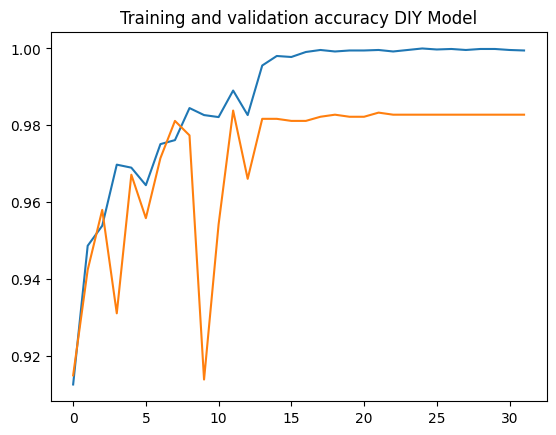

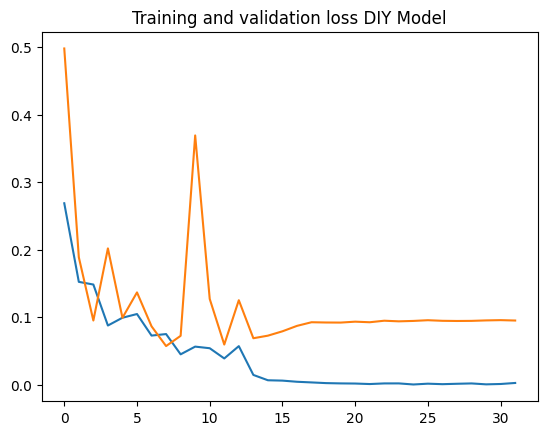

In [14]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_Xception_model_2.history['accuracy' ]
val_acc  = history_Xception_model_2.history['val_accuracy' ]
loss     = history_Xception_model_2.history['loss' ]
val_loss = history_Xception_model_2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DIY Model')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DIY Model')

# Download Model

In [16]:
!zip -r /content/Corn_Xception_model1_Based_Non_Augmented.zip /content/Corn_Xception_model1_Based_Non_Augmented

  adding: content/Corn_Xception_model1_Based_Non_Augmented/ (stored 0%)
  adding: content/Corn_Xception_model1_Based_Non_Augmented/saved_model.pb (deflated 92%)
  adding: content/Corn_Xception_model1_Based_Non_Augmented/fingerprint.pb (stored 0%)
  adding: content/Corn_Xception_model1_Based_Non_Augmented/assets/ (stored 0%)
  adding: content/Corn_Xception_model1_Based_Non_Augmented/keras_metadata.pb (deflated 96%)
  adding: content/Corn_Xception_model1_Based_Non_Augmented/variables/ (stored 0%)
  adding: content/Corn_Xception_model1_Based_Non_Augmented/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/Corn_Xception_model1_Based_Non_Augmented/variables/variables.index (deflated 77%)


In [17]:
!zip -r /content/Corn_Xception_model2_Based_Non_Augmented.zip /content/Corn_Xception_model2_Based_Non_Augmented

  adding: content/Corn_Xception_model2_Based_Non_Augmented/ (stored 0%)
  adding: content/Corn_Xception_model2_Based_Non_Augmented/saved_model.pb (deflated 92%)
  adding: content/Corn_Xception_model2_Based_Non_Augmented/fingerprint.pb (stored 0%)
  adding: content/Corn_Xception_model2_Based_Non_Augmented/assets/ (stored 0%)
  adding: content/Corn_Xception_model2_Based_Non_Augmented/keras_metadata.pb (deflated 96%)
  adding: content/Corn_Xception_model2_Based_Non_Augmented/variables/ (stored 0%)
  adding: content/Corn_Xception_model2_Based_Non_Augmented/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/Corn_Xception_model2_Based_Non_Augmented/variables/variables.index (deflated 77%)


In [ ]:
from google.colab import files

# Specify the file path
file_path_1 = '/content/Corn_Xception_model1_Based_Non_Augmented'  
file_path_2 = '/content/Corn_Xception_model2_Based_Non_Augmented'  

# Download the file
files.download(file_path_1)
files.download(file_path_2)